In [10]:
import pandas as pd
import re
from collections import Counter
from langdetect import detect
import nltk

# Ensure necessary NLTK dependencies are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
tweets = pd.read_csv(r'C:\Users\HP\Desktop\fifa_world_cup_2022_tweets.csv')

# Clean tweet text
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    return text.strip()

tweets["Cleaned_Tweet"] = tweets["Tweet"].apply(clean_tweet)

# Filter for English tweets
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

tweets = tweets[tweets["Cleaned_Tweet"].apply(is_english)]

# Remove punctuation and make lowercase
tweets["Cleaned_Tweet"] = tweets["Cleaned_Tweet"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

# Define stopwords and goal-related keywords
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) | {"amp", "like", "see", "get", "one", "today", "day", "join", "fans", "live"}
goal_keywords = {"goal", "scored", "win", "final", "match", "score", "result"}

# Regex pattern for scores (e.g., 2-1, 0-0)
score_pattern = re.compile(r"\b\d+-\d+\b")

# Predefined list of scores to match if regex fails
manual_scores = ["1-0", "0-1", "2-1", "0-0", "3-2", "1-1", "4-3", "2-2"]

# Extract scores and goal-related keywords
def extract_scores_and_keywords(text):
    scores = score_pattern.findall(text)  # Regex to find football scores
    if not scores:  # If no scores detected via regex, check manually
        scores = [score for score in manual_scores if score in text]
    keywords = [word for word in text.split() if word in goal_keywords]  # Goal-related words
    return scores, keywords

tweets["Scores"], tweets["Goal_Keywords"] = zip(*tweets["Cleaned_Tweet"].apply(extract_scores_and_keywords))

# Group by timestamp and create time buckets
tweets["Date Created"] = pd.to_datetime(tweets["Date Created"])
tweets["time_bucket"] = tweets["Date Created"].dt.floor("5min")

# Aggregate data by time bucket
def aggregate_scores_and_keywords(group):
    # Aggregate scores and keywords
    scores = Counter([score for scores in group["Scores"] for score in scores])
    keywords = Counter([kw for keywords in group["Goal_Keywords"] for kw in keywords])
    return {"scores": scores, "keywords": keywords}

aggregated_data = tweets.groupby("time_bucket").apply(aggregate_scores_and_keywords).reset_index(name="Aggregated_Data")

# Add a new column for the count of 'goal' keyword occurrences
aggregated_data["Goal_Keyword_Count"] = aggregated_data["Aggregated_Data"].apply(lambda x: x["keywords"].get("goal", 0))

# Sort by 'goal' keyword count in descending order
aggregated_data_sorted = aggregated_data.sort_values(by="Goal_Keyword_Count", ascending=False)

# Select the top 15 time buckets with the highest 'goal' keyword count
top_15_data = aggregated_data_sorted.head(15)

# Display final output
print("\nTop 15 Time Buckets with Highest 'Goal' Keyword Counts:")
for _, row in top_15_data.iterrows():
    time_bucket = row["time_bucket"]
    goal_keyword_count = row["Goal_Keyword_Count"]
    print(f"Timestamp: {time_bucket}, Goal Keyword Count: {goal_keyword_count}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 15 Time Buckets with Highest 'Goal' Keyword Counts:
Timestamp: 2022-11-20 16:05:00+00:00, Goal Keyword Count: 388
Timestamp: 2022-11-20 16:10:00+00:00, Goal Keyword Count: 340
Timestamp: 2022-11-20 16:15:00+00:00, Goal Keyword Count: 137
Timestamp: 2022-11-20 16:20:00+00:00, Goal Keyword Count: 106
Timestamp: 2022-11-20 16:35:00+00:00, Goal Keyword Count: 65
Timestamp: 2022-11-20 16:30:00+00:00, Goal Keyword Count: 58
Timestamp: 2022-11-20 16:25:00+00:00, Goal Keyword Count: 22
Timestamp: 2022-11-20 16:50:00+00:00, Goal Keyword Count: 16
Timestamp: 2022-11-20 16:40:00+00:00, Goal Keyword Count: 13
Timestamp: 2022-11-20 17:00:00+00:00, Goal Keyword Count: 11
Timestamp: 2022-11-20 16:45:00+00:00, Goal Keyword Count: 7
Timestamp: 2022-11-20 17:50:00+00:00, Goal Keyword Count: 6
Timestamp: 2022-11-20 17:25:00+00:00, Goal Keyword Count: 6
Timestamp: 2022-11-20 15:55:00+00:00, Goal Keyword Count: 6
Timestamp: 2022-11-20 17:05:00+00:00, Goal Keyword Count: 5


C:\Users\HP\AppData\Local\Temp\ipykernel_17936\2397542016.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = tweets.groupby("time_bucket").apply(aggregate_scores_and_keywords).reset_index(name="Aggregated_Data")


#croastia v/s France

In [ ]:
import pandas as pd
import re
from collections import Counter
from langdetect import detect
import nltk
from nltk.corpus import stopwords

# Ensure necessary NLTK dependencies are downloaded
nltk.download("punkt")
nltk.download("stopwords")

# Load tweets dataset
tweets = pd.read_csv(r"C:\Users\HP\Downloads\2018-07-15.csv")

# Validate dataset
required_columns = {"Date", "Tweet", "Orig_Tweet"}
if not required_columns.intersection(tweets.columns):
    raise KeyError(f"Required columns not found. Ensure the dataset contains at least one of {required_columns}.")

# Text cleaning and preprocessing
def combine_and_clean_tweets(row):
    """Combine 'Tweet' and 'Orig_Tweet' columns and clean text."""
    tweet = row.get('Tweet', "") if isinstance(row.get('Tweet', ""), str) else ""
    orig_tweet = row.get('Orig_Tweet', "") if isinstance(row.get('Orig_Tweet', ""), str) else ""
    combined_text = f"{tweet} {orig_tweet}"
    # Remove URLs, mentions, and special characters
    combined_text = re.sub(r"http\S+|www\S+|https\S+", "", combined_text)
    combined_text = re.sub(r"@\w+", "", combined_text)
    combined_text = re.sub(r"[^A-Za-z0-9\s]", "", combined_text)
    return combined_text.strip()

tweets["Cleaned_Tweet"] = tweets.apply(combine_and_clean_tweets, axis=1)

# Filter only English tweets
def is_english(text):
    """Detect language of the text."""
    try:
        return detect(text) == "en"
    except Exception:
        return False

tweets = tweets[tweets["Cleaned_Tweet"].apply(lambda x: is_english(x) if isinstance(x, str) else False)]

# Clean and tokenize text
tweets["Cleaned_Tweet"] = tweets["Cleaned_Tweet"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

# Define stopwords and goal-related keywords
stop_words = set(stopwords.words("english")) | {"amp", "like", "see", "get", "one", "today", "day", "join", "fans", "live"}
goal_keywords = {"goal", "scored", "win", "final", "match", "score", "result"}

# Regex pattern for scores
score_pattern = re.compile(r"\b\d+\s*[-:to]\s*\d+\b")  # Matches scores like "2-1", "2:1", "2 to 1"

# Extract scores and keywords
def extract_scores_and_keywords(text):
    """Extract football scores and goal-related keywords from text."""
    scores = score_pattern.findall(text)
    keywords = [word for word in text.split() if word in goal_keywords]
    return scores, keywords

tweets[["Scores", "Goal_Keywords"]] = tweets["Cleaned_Tweet"].apply(
    lambda x: pd.Series(extract_scores_and_keywords(x))
)

# Convert 'Date' column to datetime format and remove invalid entries
tweets["Date"] = pd.to_datetime(tweets["Date"], errors="coerce")
tweets = tweets.dropna(subset=["Date"])

tweets["time_bucket"] = tweets["Date"].dt.floor("2min")

# Aggregate data by time bucket
def aggregate_data(group):
    """Aggregate scores and keywords for a time bucket."""
    scores = Counter(score for scores in group["Scores"] for score in scores)
    keywords = Counter(keyword for keywords in group["Goal_Keywords"] for keyword in keywords)
    return {"scores": scores, "keywords": keywords}

aggregated_data = tweets.groupby("time_bucket").apply(aggregate_data).reset_index(name="Aggregated_Data")

# Display final aggregated output
def display_aggregated_output(aggregated_data):
    """Print the aggregated scores and keywords."""
    print("\nFinal Aggregated Output:")
    for _, row in aggregated_data.iterrows():
        time_bucket = row["time_bucket"]
        scores = row["Aggregated_Data"]["scores"].most_common()
        keywords = row["Aggregated_Data"]["keywords"].most_common(10)  # Top 10 keywords
        scores_str = ", ".join([f"{score} goals" for score, _ in scores]) if scores else "No scores"
        keywords_str = ", ".join([f"{keyword} ({count})" for keyword, count in keywords]) if keywords else "No keywords"
        print(f"Timestamp: {time_bucket}, Keywords: {keywords_str}")

display_aggregated_output(aggregated_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\HP\AppData\Local\Temp\ipykernel_17936\1387209386.py:66: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tweets["Date"] = pd.to_datetime(tweets["Date"], errors="coerce")



Final Aggregated Output:
Timestamp: 2018-07-15 04:32:00, Keywords: final (12), win (4), goal (2)
Timestamp: 2018-07-15 04:34:00, Keywords: final (107), win (32), score (4), match (3), goal (2)
Timestamp: 2018-07-15 04:36:00, Keywords: final (100), win (24), score (6), goal (6), scored (4), match (2)
Timestamp: 2018-07-15 04:38:00, Keywords: final (113), win (15), goal (6), score (2), match (2)
Timestamp: 2018-07-15 04:40:00, Keywords: final (107), win (21), match (6), score (2), goal (2)
Timestamp: 2018-07-15 04:42:00, Keywords: final (117), win (42), score (4), match (2)
Timestamp: 2018-07-15 04:44:00, Keywords: final (76), win (18), match (4), scored (2), goal (2)
Timestamp: 2018-07-15 04:46:00, Keywords: final (102), win (26), match (9), goal (4)
Timestamp: 2018-07-15 04:48:00, Keywords: final (100), win (31), goal (6), match (4)
Timestamp: 2018-07-15 04:50:00, Keywords: final (101), win (9), scored (2), goal (2), result (2), match (1)
Timestamp: 2018-07-15 04:52:00, Keywords: fina

C:\Users\HP\AppData\Local\Temp\ipykernel_17936\1387209386.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = tweets.groupby("time_bucket").apply(aggregate_data).reset_index(name="Aggregated_Data")


In [44]:
import pandas as pd
import re
from langdetect import detect
import nltk

# Ensure necessary NLTK dependencies are downloaded
nltk.download("punkt")
nltk.download("stopwords")

# Load the tweets dataset
tweets = pd.read_csv(r"C:\Users\HP\Downloads\2018-07-15.csv")

# Validate dataset
required_columns = {"Date", "Tweet", "Orig_Tweet"}
if not required_columns.intersection(tweets.columns):
    raise KeyError(f"Required columns not found. Ensure the dataset contains at least one of {required_columns}.")

# Text cleaning and preprocessing
def combine_and_clean_tweets(row):
    """Combine 'Tweet' and 'Orig_Tweet' columns and clean text."""
    tweet = row.get('Tweet', "") if isinstance(row.get('Tweet', ""), str) else ""
    orig_tweet = row.get('Orig_Tweet', "") if isinstance(row.get('Orig_Tweet', ""), str) else ""
    combined_text = f"{tweet} {orig_tweet}"
    # Remove URLs, mentions, and special characters
    combined_text = re.sub(r"http\S+|www\S+|https\S+", "", combined_text)
    combined_text = re.sub(r"@\w+", "", combined_text)
    combined_text = re.sub(r"[^A-Za-z0-9\s]", "", combined_text)
    return combined_text.strip()

tweets["Cleaned_Tweet"] = tweets.apply(combine_and_clean_tweets, axis=1)

# Filter only English tweets
def is_english(text):
    """Detect language of the text."""
    try:
        return detect(text) == "en"
    except Exception:
        return False

tweets = tweets[tweets["Cleaned_Tweet"].apply(lambda x: is_english(x) if isinstance(x, str) else False)]

# Clean and tokenize text
tweets["Cleaned_Tweet"] = tweets["Cleaned_Tweet"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

# Extract count of "goal" keyword
tweets["Goal_Count"] = tweets["Cleaned_Tweet"].apply(lambda x: x.split().count("goal"))

# Convert 'Date' column to datetime format and remove invalid entries
tweets["Date"] = pd.to_datetime(tweets["Date"], errors="coerce")
tweets = tweets.dropna(subset=["Date"])

# Create time buckets (2-minute intervals)
tweets["time_bucket"] = tweets["Date"].dt.floor("2min")

# Aggregate data by time bucket
def aggregate_goal_data(group):
    """Aggregate the count of 'goal' keyword for a time bucket."""
    total_goal_count = group["Goal_Count"].sum()
    return {"goal_count": total_goal_count}

aggregated_data = tweets.groupby("time_bucket").apply(aggregate_goal_data).reset_index(name="Aggregated_Data")

# Add a column to hold the total count of "goal" keyword
aggregated_data["Goal_Count"] = aggregated_data["Aggregated_Data"].apply(lambda x: x["goal_count"])

# Sort by Goal_Count in descending order
aggregated_data = aggregated_data.sort_values(by="Goal_Count", ascending=False)

# Select the top 24 records
top_24_data = aggregated_data.head(24)

# Display final aggregated output
def display_aggregated_output(aggregated_data):
    """Print the aggregated 'goal' counts."""
    print("\nTop 24 Timestamps with Highest 'Goal' Counts:")
    for _, row in aggregated_data.iterrows():
        time_bucket = row["time_bucket"]
        goal_count = row["Goal_Count"]
        print(f"Timestamp: {time_bucket}, Goal Count: {goal_count}")

display_aggregated_output(top_24_data)

# Extract the top 24 peaks (changed to 24 from 20)
top_24_peaks = aggregated_data.nlargest(24, "Goal_Count")

# Print the top 24 peaks
print("\nTop Timestamps with Highest Peaks:")
print(top_24_peaks[["time_bucket", "Goal_Count"]])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\HP\AppData\Local\Temp\ipykernel_4440\1712712672.py:49: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tweets["Date"] = pd.to_datetime(tweets["Date"], errors="coerce")



Top 24 Timestamps with Highest 'Goal' Counts:
Timestamp: 2018-07-15 17:48:00, Goal Count: 160
Timestamp: 2018-07-15 17:38:00, Goal Count: 159
Timestamp: 2018-07-15 17:36:00, Goal Count: 152
Timestamp: 2018-07-15 17:44:00, Goal Count: 132
Timestamp: 2018-07-15 17:52:00, Goal Count: 131
Timestamp: 2018-07-15 17:56:00, Goal Count: 130
Timestamp: 2018-07-15 17:50:00, Goal Count: 111
Timestamp: 2018-07-15 17:40:00, Goal Count: 109
Timestamp: 2018-07-15 17:42:00, Goal Count: 109
Timestamp: 2018-07-15 17:46:00, Goal Count: 104
Timestamp: 2018-07-15 17:54:00, Goal Count: 102
Timestamp: 2018-07-15 18:00:00, Goal Count: 98
Timestamp: 2018-07-15 18:02:00, Goal Count: 85
Timestamp: 2018-07-15 18:04:00, Goal Count: 83
Timestamp: 2018-07-15 18:10:00, Goal Count: 72
Timestamp: 2018-07-15 18:14:00, Goal Count: 70
Timestamp: 2018-07-15 18:12:00, Goal Count: 70
Timestamp: 2018-07-15 18:08:00, Goal Count: 65
Timestamp: 2018-07-15 17:58:00, Goal Count: 62
Timestamp: 2018-07-15 18:06:00, Goal Count: 46
Ti

C:\Users\HP\AppData\Local\Temp\ipykernel_4440\1712712672.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = tweets.groupby("time_bucket").apply(aggregate_goal_data).reset_index(name="Aggregated_Data")



Combined Significant Event Timestamps and Goal Counts:
           time_bucket  Goal_Count formatted_time
3  2018-07-15 17:36:00       152.0          36:00
4  2018-07-15 17:38:00       159.0          38:00
5  2018-07-15 17:40:00       107.0          40:00
6  2018-07-15 17:42:00       109.0          42:00
7  2018-07-15 17:44:00       134.0          44:00
8  2018-07-15 17:46:00       104.0          46:00
9  2018-07-15 17:48:00       160.0          48:00
10 2018-07-15 17:52:00       131.0          52:00
11 2018-07-15 17:56:00       130.0          56:00
12 2018-07-15 17:58:00        62.0          58:00
13 2018-07-15 18:00:00        98.0          60:00
14 2018-07-15 18:04:00        83.0          64:00
15 2018-07-15 18:06:00        46.0          66:00
16 2018-07-15 18:08:00        65.0          68:00
17 2018-07-15 18:10:00        72.0          70:00
18 2018-07-15 18:12:00        70.0          72:00
19 2018-07-15 18:14:00        70.0          74:00


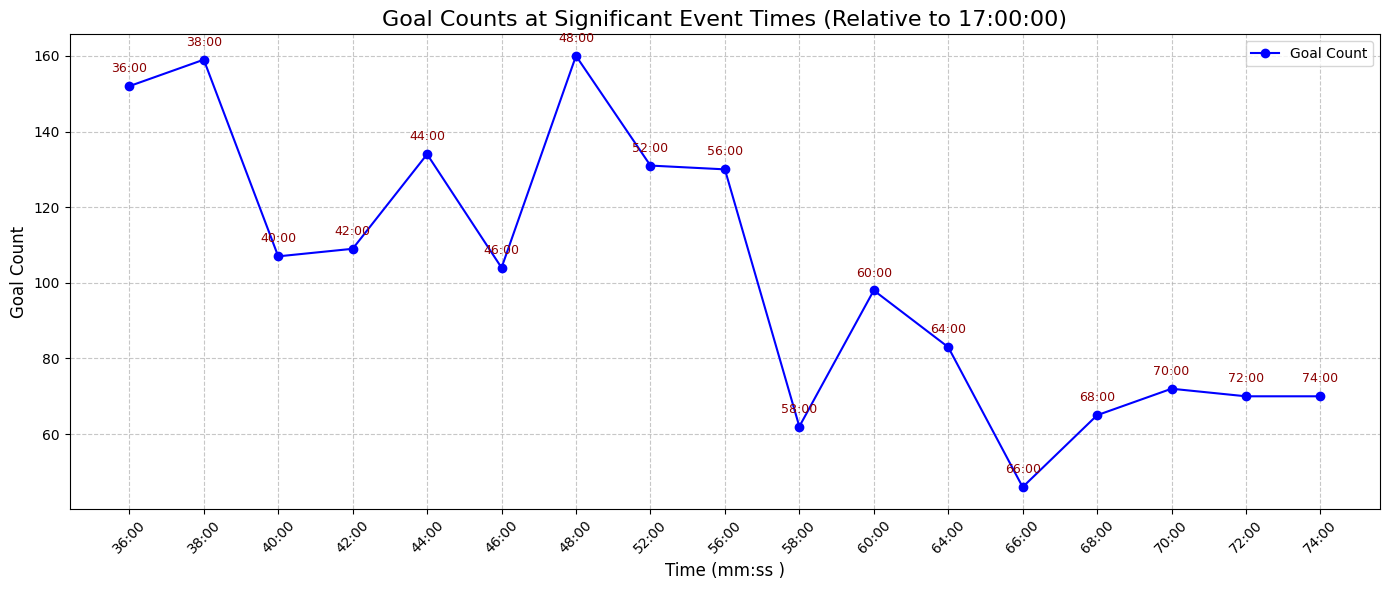

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# List of significant event timestamps
significant_events = [
    "2018-07-15 06:58:00", "2018-07-15 07:00:00", "2018-07-15 07:02:00",
    "2018-07-15 17:36:00", "2018-07-15 17:38:00", "2018-07-15 17:40:00",
    "2018-07-15 17:42:00", "2018-07-15 17:44:00", "2018-07-15 17:46:00",
    "2018-07-15 17:48:00", "2018-07-15 17:52:00", "2018-07-15 17:56:00",
    "2018-07-15 17:58:00", "2018-07-15 18:00:00", "2018-07-15 18:04:00",
    "2018-07-15 18:06:00", "2018-07-15 18:08:00", "2018-07-15 18:10:00",
    "2018-07-15 18:12:00", "2018-07-15 18:14:00", "2018-07-15 18:16:00",
    "2018-07-15 22:48:00", "2018-07-15 23:04:00", "2018-07-15 23:10:00"
]

# Data for Top 20 Timestamps with Highest Peaks
top_20_data = {
    "time_bucket": [
        "2018-07-15 17:48:00", "2018-07-15 17:38:00", "2018-07-15 17:36:00",
        "2018-07-15 17:44:00", "2018-07-15 17:52:00", "2018-07-15 17:56:00",
        "2018-07-15 17:50:00", "2018-07-15 17:42:00", "2018-07-15 17:40:00",
        "2018-07-15 17:46:00", "2018-07-15 17:54:00", "2018-07-15 18:00:00",
        "2018-07-15 18:02:00", "2018-07-15 18:04:00", "2018-07-15 18:10:00",
        "2018-07-15 18:14:00", "2018-07-15 18:12:00", "2018-07-15 18:08:00",
        "2018-07-15 17:58:00", "2018-07-15 18:06:00"
    ],
    "Goal_Count": [
        160, 159, 152, 134, 131, 130, 111, 109, 107, 104, 100, 98, 85, 83, 72,
        70, 70, 65, 62, 46
    ]
}

# Convert both lists into DataFrames
significant_events_df = pd.DataFrame({"time_bucket": pd.to_datetime(significant_events)})
top_20_df = pd.DataFrame(top_20_data)
top_20_df["time_bucket"] = pd.to_datetime(top_20_df["time_bucket"])

# Sort the dataframes by 'time_bucket' before merging
significant_events_df.sort_values(by="time_bucket", inplace=True)
top_20_df.sort_values(by="time_bucket", inplace=True)

# Merge the two DataFrames on 'time_bucket', with an outer join to include all timestamps from both datasets
combined_df = pd.merge(significant_events_df, top_20_df, on="time_bucket", how="left")

# Fill in Goal_Count as NaN for timestamps that don't match in the top 20 dataset
combined_df["Goal_Count"] = combined_df["Goal_Count"].fillna(0)

# Remove rows where Goal_Count is 0
combined_df = combined_df[combined_df["Goal_Count"] > 0]

# Sort the combined dataframe by 'time_bucket' for clarity
combined_df.sort_values(by="time_bucket", inplace=True)

# Define the base time "17:00:00" to subtract from each timestamp
base_time = pd.to_datetime("2018-07-15 17:00:00")

# Calculate the difference between the event time and 17:00:00
combined_df['time_diff'] = combined_df['time_bucket'] - base_time

# Convert the time difference into minutes and seconds (mm:ss format)
combined_df['time_only'] = combined_df['time_diff'].dt.total_seconds() // 60
combined_df['seconds'] = combined_df['time_diff'].dt.total_seconds() % 60

# Ensure seconds and minutes are formatted correctly with leading zeros (mm:ss)
combined_df['formatted_time'] = combined_df['time_only'].apply(lambda x: f"{int(x):02}") + ":" + combined_df['seconds'].apply(lambda x: f"{int(x):02}")

# Display the final combined data
print("\nCombined Significant Event Timestamps and Goal Counts:")
print(combined_df[['time_bucket', 'Goal_Count', 'formatted_time']])  # Show formatted time only

# Create a plot visualizing the Timestamps at Significant Events (using only the time)
def plot_goal_counts_with_time(combined_df):
    plt.figure(figsize=(14, 6))
    
    # Plot goal counts against the time (ignoring the date)
    plt.plot(combined_df['formatted_time'], combined_df['Goal_Count'], color='blue', marker='o', label="Goal Count")
    
    # Annotate each point on the plot with its time_only value
    for _, row in combined_df.iterrows():
        plt.annotate(f"{row['formatted_time']}",
                     (row['formatted_time'], row['Goal_Count']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='darkred')

    plt.title("Goal Counts at Significant Event Times (Relative to 17:00:00)", fontsize=16)
    plt.xlabel("Time (mm:ss )", fontsize=12)
    plt.ylabel("Goal Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_goal_counts_with_time(combined_df)



Combined Significant Event Timestamps and Goal Counts:
           time_bucket  Goal_Count formatted_time
3  2018-07-15 17:36:00       152.0          36:00
4  2018-07-15 17:38:00       159.0          38:00
5  2018-07-15 17:40:00       107.0          40:00
6  2018-07-15 17:42:00       109.0          42:00
7  2018-07-15 17:44:00       134.0          44:00
8  2018-07-15 17:46:00       104.0          46:00
9  2018-07-15 17:48:00       160.0          48:00
10 2018-07-15 17:52:00       131.0          52:00
11 2018-07-15 17:56:00       130.0          56:00
12 2018-07-15 17:58:00        62.0          58:00
13 2018-07-15 18:00:00        98.0          60:00
14 2018-07-15 18:04:00        83.0          64:00
15 2018-07-15 18:06:00        46.0          66:00
16 2018-07-15 18:08:00        65.0          68:00
17 2018-07-15 18:10:00        72.0          70:00
18 2018-07-15 18:12:00        70.0          72:00
19 2018-07-15 18:14:00        70.0          74:00


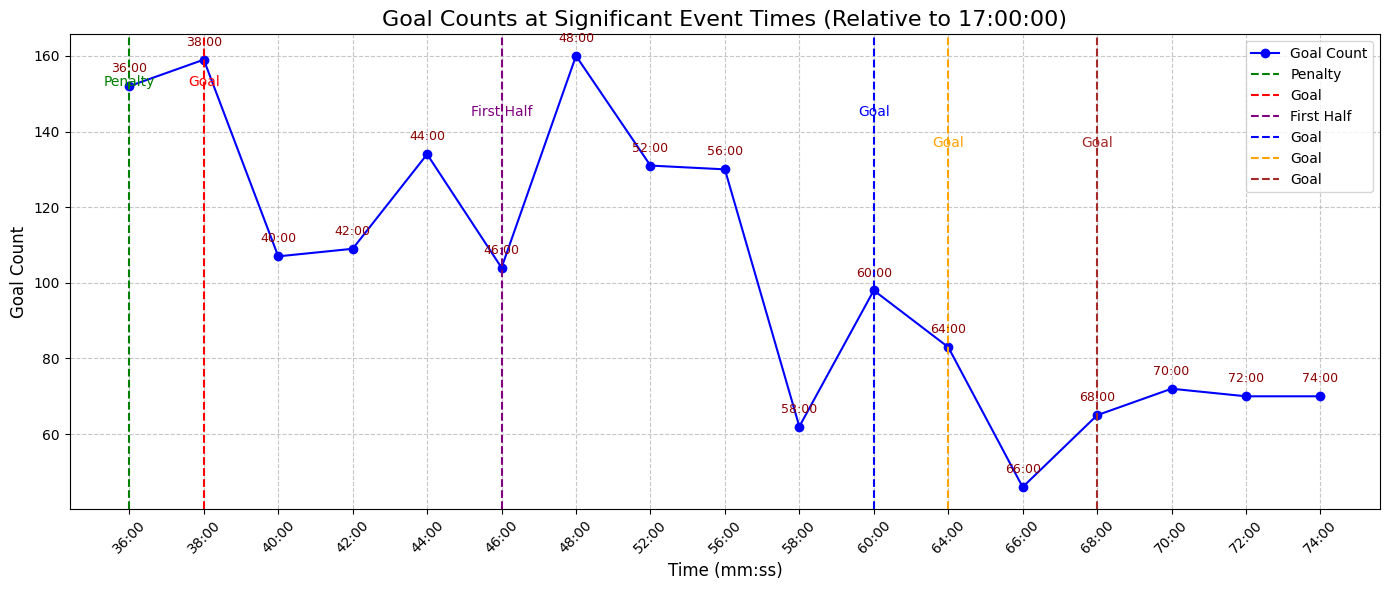

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# List of significant event timestamps
significant_events = [
    "2018-07-15 06:58:00", "2018-07-15 07:00:00", "2018-07-15 07:02:00",
    "2018-07-15 17:36:00", "2018-07-15 17:38:00", "2018-07-15 17:40:00",
    "2018-07-15 17:42:00", "2018-07-15 17:44:00", "2018-07-15 17:46:00",
    "2018-07-15 17:48:00", "2018-07-15 17:52:00", "2018-07-15 17:56:00",
    "2018-07-15 17:58:00", "2018-07-15 18:00:00", "2018-07-15 18:04:00",
    "2018-07-15 18:06:00", "2018-07-15 18:08:00", "2018-07-15 18:10:00",
    "2018-07-15 18:12:00", "2018-07-15 18:14:00", "2018-07-15 18:16:00",
    "2018-07-15 22:48:00", "2018-07-15 23:04:00", "2018-07-15 23:10:00"
]

# Data for Top 20 Timestamps with Highest Peaks
top_20_data = {
    "time_bucket": [
        "2018-07-15 17:48:00", "2018-07-15 17:38:00", "2018-07-15 17:36:00",
        "2018-07-15 17:44:00", "2018-07-15 17:52:00", "2018-07-15 17:56:00",
        "2018-07-15 17:50:00", "2018-07-15 17:42:00", "2018-07-15 17:40:00",
        "2018-07-15 17:46:00", "2018-07-15 17:54:00", "2018-07-15 18:00:00",
        "2018-07-15 18:02:00", "2018-07-15 18:04:00", "2018-07-15 18:10:00",
        "2018-07-15 18:14:00", "2018-07-15 18:12:00", "2018-07-15 18:08:00",
        "2018-07-15 17:58:00", "2018-07-15 18:06:00"
    ],
    "Goal_Count": [
        160, 159, 152, 134, 131, 130, 111, 109, 107, 104, 100, 98, 85, 83, 72,
        70, 70, 65, 62, 46
    ]
}

# Convert both lists into DataFrames
significant_events_df = pd.DataFrame({"time_bucket": pd.to_datetime(significant_events)})
top_20_df = pd.DataFrame(top_20_data)
top_20_df["time_bucket"] = pd.to_datetime(top_20_df["time_bucket"])

# Sort the dataframes by 'time_bucket' before merging
significant_events_df.sort_values(by="time_bucket", inplace=True)
top_20_df.sort_values(by="time_bucket", inplace=True)

# Merge the two DataFrames on 'time_bucket', with an outer join to include all timestamps from both datasets
combined_df = pd.merge(significant_events_df, top_20_df, on="time_bucket", how="left")

# Fill in Goal_Count as NaN for timestamps that don't match in the top 20 dataset
combined_df["Goal_Count"] = combined_df["Goal_Count"].fillna(0)

# Remove rows where Goal_Count is 0
combined_df = combined_df[combined_df["Goal_Count"] > 0]

# Sort the combined dataframe by 'time_bucket' for clarity
combined_df.sort_values(by="time_bucket", inplace=True)

# Define the base time "17:00:00" to subtract from each timestamp
base_time = pd.to_datetime("2018-07-15 17:00:00")

# Calculate the difference between the event time and 17:00:00
combined_df['time_diff'] = combined_df['time_bucket'] - base_time

# Convert the time difference into minutes and seconds (mm:ss format)
combined_df['time_only'] = combined_df['time_diff'].dt.total_seconds() // 60
combined_df['seconds'] = combined_df['time_diff'].dt.total_seconds() % 60

# Ensure seconds and minutes are formatted correctly with leading zeros (mm:ss)
combined_df['formatted_time'] = combined_df['time_only'].apply(lambda x: f"{int(x):02}") + ":" + combined_df['seconds'].apply(lambda x: f"{int(x):02}")

# Display the final combined data
print("\nCombined Significant Event Timestamps and Goal Counts:")
print(combined_df[['time_bucket', 'Goal_Count', 'formatted_time']])  # Show formatted time only

# Create a plot visualizing the Timestamps at Significant Events (using only the time)
def plot_goal_counts_with_time(combined_df):
    plt.figure(figsize=(14, 6))

    # Plot goal counts against the time (ignoring the date)
    plt.plot(combined_df['formatted_time'], combined_df['Goal_Count'], color='blue', marker='o', label="Goal Count")
    
    # Annotate each point on the plot with its time_only value
    for _, row in combined_df.iterrows():
        plt.annotate(f"{row['formatted_time']}",
                     (row['formatted_time'], row['Goal_Count']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='darkred')

    # Add additional specific event markers
    plt.axvline(x="36:00", color='green', linestyle='--', label="Penalty")  # Penalty at 36:00
    plt.text("36:00", max(combined_df['Goal_Count']) * 0.95, 'Penalty', color='green', ha='center', fontsize=10)

    plt.axvline(x="38:00", color='red', linestyle='--', label="Goal")  # Goal at 38:00
    plt.text("38:00", max(combined_df['Goal_Count']) * 0.95, 'Goal', color='red', ha='center', fontsize=10)

    plt.axvline(x="46:00", color='purple', linestyle='--', label="First Half")  # First Half at 46:00
    plt.text("46:00", max(combined_df['Goal_Count']) * 0.90, 'First Half', color='purple', ha='center', fontsize=10)

    plt.axvline(x="60:00", color='blue', linestyle='--', label="Goal")  # Goal at 60:00
    plt.text("60:00", max(combined_df['Goal_Count']) * 0.90, 'Goal', color='blue', ha='center', fontsize=10)

    plt.axvline(x="64:00", color='orange', linestyle='--', label="Goal")  # Goal at 64:00
    plt.text("64:00", max(combined_df['Goal_Count']) * 0.85, 'Goal', color='orange', ha='center', fontsize=10)

    plt.axvline(x="68:00", color='brown', linestyle='--', label="Goal")  # Goal at 68:00
    plt.text("68:00", max(combined_df['Goal_Count']) * 0.85, 'Goal', color='brown', ha='center', fontsize=10)

    plt.title("Goal Counts at Significant Event Times (Relative to 17:00:00)", fontsize=16)
    plt.xlabel("Time (mm:ss)", fontsize=12)
    plt.ylabel("Goal Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_goal_counts_with_time(combined_df)


In [1]:
import pandas as pd
import numpy as np

# Ground truth and predicted timestamps
y_true = ["27:58", "38:00", "64:00", "68:00", "58:00"]
y_pred = ["36:00", "38:00", "40:00", "42:00", "44:00", "46:00", "48:00", "52:00", "56:00", "58:00", "60:00", "64:00", "66:00", "68:00", "70:00", "72:00", "74:00"]

# Convert the lists to pandas Series
y_true = pd.Series(y_true)
y_pred = pd.Series(y_pred)

# Convert the time strings to pandas Timedelta for easier comparison
y_true = pd.to_timedelta(y_true.str.split(":").str[0].astype(int), unit='m') + pd.to_timedelta(y_true.str.split(":").str[1].astype(int), unit='s')
y_pred = pd.to_timedelta(y_pred.str.split(":").str[0].astype(int), unit='m') + pd.to_timedelta(y_pred.str.split(":").str[1].astype(int), unit='s')

# Define an acceptable time window (e.g., within 30 seconds)
time_window = pd.Timedelta(seconds=30)

# Initialize counters for true positives, false positives, and false negatives
tp, fp, fn = 0, 0, 0

# Calculate true positives, false positives, and false negatives
for true_time in y_true:
    matched = False
    for pred_time in y_pred:
        if abs(true_time - pred_time) <= time_window:
            tp += 1
            y_pred = y_pred[y_pred != pred_time]  # Remove the matched prediction
            matched = True
            break
    if not matched:
        fn += 1

# False positives are the remaining predictions that didn't match any true time
fp = len(y_pred)

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) * 100 if tp + fp > 0 else 0
recall = tp / (tp + fn) * 100 if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
accuracy = (tp + len(y_pred)) / (tp + fn + fp + len(y_pred)) * 100  # total correct predictions / total predictions

# Print the metrics

print(f"Recall: {recall:.2f}%")

print(f"Accuracy: {accuracy:.2f}%")


Recall: 80.00%
Accuracy: 54.84%


In [ ]:
import pandas as pd
import re
from langdetect import detect
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Ensure NLTK dependencies are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load tweets
tweets = pd.read_csv(r'C:\Users\HP\Downloads\2018-07-15.csv')

# Define function to combine and clean tweet text
def combine_tweets(row):
    """Combine 'Tweet' and 'Orig_Tweet' columns and clean."""
    tweet_text = row['Tweet'] if isinstance(row['Tweet'], str) else ""
    orig_tweet_text = row['Orig_Tweet'] if isinstance(row['Orig_Tweet'], str) else ""
    combined_text = tweet_text + " " + orig_tweet_text
    # Cleaning: Remove URLs, mentions, and non-alphanumeric characters
    combined_text = re.sub(r"http\S+|www\S+|https\S+", '', combined_text, flags=re.MULTILINE)
    combined_text = re.sub(r'@\w+', '', combined_text)  # Remove @mentions
    combined_text = re.sub(r'[^A-Za-z0-9\s]', '', combined_text)  # Remove special characters
    return combined_text.strip()

# Apply cleaning to rows where 'Tweet' or 'Orig_Tweet' is not null
tweets['Cleaned_Tweet'] = tweets.apply(combine_tweets, axis=1)

# Detect and filter only English tweets
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

tweets = tweets[tweets['Cleaned_Tweet'].apply(is_english)]

# Further cleaning: lowercasing and removing punctuation
tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.lower()
tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.replace('[^\w\s]', '', regex=True)

stop_words = set(stopwords.words('english')) | {"the", "to", "and", "of", "in", "for", "on", "with", "a", "worldcup2022", "cup", "world", "fifaworldcup", "today", "2022", "team", "football", "qatarworldcup2022", "worldcup"}
tweets['Tokens'] = tweets['Cleaned_Tweet'].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Time Bucketing
tweets['Date'] = pd.to_datetime(tweets['Date'])
tweets['time_bucket'] = tweets['Date'].dt.floor('2min')
super_documents = tweets.groupby('time_bucket')['Tokens'].apply(lambda tokens_list: ' '.join([' '.join(tokens) for tokens in tokens_list])).reset_index()

# Create Co-occurrence Graphs for each time bucket
graphs = []
window_size = 2

for _, row in super_documents.iterrows():
    G = nx.Graph()
    words = row['Tokens'].split()
    for i in range(len(words)):
        for j in range(i + 1, min(i + window_size, len(words))):
            word1, word2 = words[i], words[j]
            G.add_edge(word1, word2, weight=G[word1][word2]['weight'] + 1 if G.has_edge(word1, word2) else 1)
    graphs.append(G)

# Calculate Growth Factor and Aggregated Centrality
def calculate_growth_factor(graphs):
    growth_factors = []
    for i in range(len(graphs) - 1):
        total_weight_current = sum(data['weight'] for _, _, data in graphs[i].edges(data=True))
        total_weight_next = sum(data['weight'] for _, _, data in graphs[i + 1].edges(data=True))
        growth_factor = total_weight_next - total_weight_current
        growth_factors.append(growth_factor)
    return growth_factors

def calculate_aggregated_centrality(graphs):
    aggregated_centralities = []
    for G in graphs:
        centrality = nx.degree_centrality(G)
        aggregated_centrality = sum(centrality.values())
        aggregated_centralities.append(aggregated_centrality)
    return aggregated_centralities

GF = calculate_growth_factor(graphs)
AC = calculate_aggregated_centrality(graphs)

# Calculate Heartbeat Score
def calculate_heartbeat_score(GF, AC):
    heartbeat_scores = []
    for gf, ac in zip(GF, AC[1:]):
        heartbeat_score = gf * ac
        heartbeat_scores.append(heartbeat_score)
    return heartbeat_scores

heartbeat_scores = calculate_heartbeat_score(GF, AC)

# Event Classification based on Heartbeat Score
def classify_events(heartbeat_scores, threshold=10000):
    event_labels = []
    for i in range(1, len(heartbeat_scores)):
        score_change = abs(heartbeat_scores[i] - heartbeat_scores[i - 1])
        event_labels.append(1 if score_change > threshold else 0)  # Mark as significant if change exceeds threshold
    return event_labels

event_labels = classify_events(heartbeat_scores)

# Extract Significant Events with Corresponding Timestamps (only timestamps)
event_candidates_indices = [i for i, label in enumerate(event_labels) if label == 1]
significant_event_timestamps = []

for idx in event_candidates_indices:
    timestamp = super_documents.iloc[idx]['time_bucket']
    significant_event_timestamps.append(timestamp)

# Output significant event timestamps only
print("\nSignificant Event Timestamps:\n")
for timestamp in significant_event_timestamps:
    print(timestamp)

<>:42: SyntaxWarning: invalid escape sequence '\w'
<>:42: SyntaxWarning: invalid escape sequence '\w'
C:\Users\HP\AppData\Local\Temp\ipykernel_15448\3392543056.py:42: SyntaxWarning: invalid escape sequence '\w'
  tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.replace('[^\w\s]', '', regex=True)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\HP\AppData\Local\Temp\ipykernel_15448\3392543056.py:48: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tweets['Date'] = pd.to_datetime(tweets['Date'])



Significant Event Timestamps:

2018-07-15 06:58:00
2018-07-15 07:00:00
2018-07-15 07:02:00
2018-07-15 17:36:00
2018-07-15 17:38:00
2018-07-15 17:40:00
2018-07-15 17:42:00
2018-07-15 17:44:00
2018-07-15 17:46:00
2018-07-15 17:48:00
2018-07-15 17:52:00
2018-07-15 17:56:00
2018-07-15 17:58:00
2018-07-15 18:00:00
2018-07-15 18:04:00
2018-07-15 18:06:00
2018-07-15 18:08:00
2018-07-15 18:10:00
2018-07-15 18:12:00
2018-07-15 18:14:00
2018-07-15 18:16:00
2018-07-15 22:48:00
2018-07-15 23:04:00
2018-07-15 23:10:00


france v/s croastia

Qater v/s ecuder

In [1]:
import pandas as pd
import re
from langdetect import detect
import nltk
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np

# Ensure NLTK dependencies are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
tweets = pd.read_csv(r'C:\Users\HP\Desktop\fifa_world_cup_2022_tweets.csv')

# Clean tweets
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtag symbols
    return text

tweets['Cleaned_Tweet'] = tweets['Tweet'].apply(clean_tweet)

# Detect and filter only English tweets
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

tweets = tweets[tweets['Cleaned_Tweet'].apply(is_english)]

# Further cleaning: lowercasing and removing punctuation
tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.lower()
tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.replace('[^\w\s]', '', regex=True)

# Tokenize and remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) | {
    "the", "to", "and", "of", "in", "for", "on", "with", "a", "worldcup2022",
    "cup", "world", "fifaworldcup", "today", "2022", "team", "football", "qatarworldcup2022", "worldcup"
}

tweets['Tokens'] = tweets['Cleaned_Tweet'].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Create time buckets
tweets['Date Created'] = pd.to_datetime(tweets['Date Created'])
tweets['time_bucket'] = tweets['Date Created'].dt.floor('2min')

# Combine tokens into super-documents per time bucket
super_documents = tweets.groupby('time_bucket')['Tokens'] \
    .apply(lambda tokens_list: ' '.join([' '.join(tokens) for tokens in tokens_list])) \
    .reset_index()

# Create co-occurrence graphs
graphs = []
window_size = 2

for _, row in super_documents.iterrows():
    G = nx.Graph()
    words = row['Tokens'].split()

    for i in range(len(words)):
        for j in range(i + 1, min(i + window_size, len(words))):
            word1, word2 = words[i], words[j]
            if G.has_edge(word1, word2):
                G[word1][word2]['weight'] += 1
            else:
                G.add_edge(word1, word2, weight=1)

    graphs.append(G)

# Calculate Growth Factor and Aggregated Centrality
def calculate_growth_factor(graphs):
    growth_factors = []
    for i in range(len(graphs) - 1):
        total_weight_current = sum(data['weight'] for _, _, data in graphs[i].edges(data=True))
        total_weight_next = sum(data['weight'] for _, _, data in graphs[i + 1].edges(data=True))
        growth_factor = total_weight_next - total_weight_current
        growth_factors.append(growth_factor)
    return growth_factors

def calculate_aggregated_centrality(graphs):
    aggregated_centralities = []
    for G in graphs:
        centrality = nx.degree_centrality(G)
        aggregated_centrality = sum(centrality.values())
        aggregated_centralities.append(aggregated_centrality)
    return aggregated_centralities

GF = calculate_growth_factor(graphs)
AC = calculate_aggregated_centrality(graphs)

# Calculate Heartbeat Score
def calculate_heartbeat_score(GF, AC):
    heartbeat_scores = []
    for gf, ac in zip(GF, AC[1:]):
        heartbeat_score = gf * ac
        heartbeat_scores.append(heartbeat_score)
    return heartbeat_scores

heartbeat_scores = calculate_heartbeat_score(GF, AC)

# Rank Events by Heartbeat Score and Extract Top 10
significant_event_indices = np.argsort(heartbeat_scores)[-10:]  # Indices of top 10 significant events
significant_event_indices = sorted(significant_event_indices)  # Sort indices chronologically

# Extract significant events and their keywords
significant_events = []

for idx in significant_event_indices:
    time_bucket = super_documents.iloc[idx]['time_bucket']
    tokens = super_documents.iloc[idx]['Tokens'].split()
    G = nx.Graph()

    for i in range(len(tokens)):
        for j in range(i + 1, min(i + window_size, len(tokens))):
            word1, word2 = tokens[i], tokens[j]
            if G.has_edge(word1, word2):
                G[word1][word2]['weight'] += 1
            else:
                G.add_edge(word1, word2, weight=1)

    # Extract top 10 keywords based on centrality
    centrality = nx.degree_centrality(G)
    sorted_keywords = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    keywords = [word for word, _ in sorted_keywords[:10]]
    significant_events.append((time_bucket, keywords))

# Output Top 10 Significant Events
print("Top 10 Significant Events:")
for timestamp, keywords in significant_events:
    print(f"Timestamp: {timestamp}, Keywords: {', '.join(keywords)}")


<>:37: SyntaxWarning: invalid escape sequence '\w'
<>:37: SyntaxWarning: invalid escape sequence '\w'
C:\Users\HP\AppData\Local\Temp\ipykernel_15512\93444280.py:37: SyntaxWarning: invalid escape sequence '\w'
  tweets['Cleaned_Tweet'] = tweets['Cleaned_Tweet'].str.replace('[^\w\s]', '', regex=True)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 Significant Events:
Timestamp: 2022-11-20 09:58:00+00:00, Keywords: qatar, luck, us, whos, win, hi, market, gt, game, ecuador
Timestamp: 2022-11-20 10:58:00+00:00, Keywords: qatar, qatar2022, win, group, time, fifa, know, lets, cheers, lodge
Timestamp: 2022-11-20 14:42:00+00:00, Keywords: qatar2022, ceremony, opening, go, fifa, qatar, watch, lets, live, openingceremony
Timestamp: 2022-11-20 14:58:00+00:00, Keywords: ceremony, qatar, opening, qatar2022, fifa, songs, get, worldcupqatar2022, waka, jungkook
Timestamp: 2022-11-20 16:02:00+00:00, Keywords: qatar, go, time, ecuador, qatar2022, lets, kick, match, game, fifa
Timestamp: 2022-11-20 16:04:00+00:00, Keywords: qatar, ecuador, first, qatar2022, go, already, watch, game, fifa, worldcupqatar2022
Timestamp: 2022-11-20 16:06:00+00:00, Keywords: qatar, ecuador, goal, first, start, already, qatar2022, var, game, 3
Timestamp: 2022-11-20 16:16:00+00:00, Keywords: var, qatar, offside, penalty, goal, qatar2022, ecuador, qatecu, worldcup

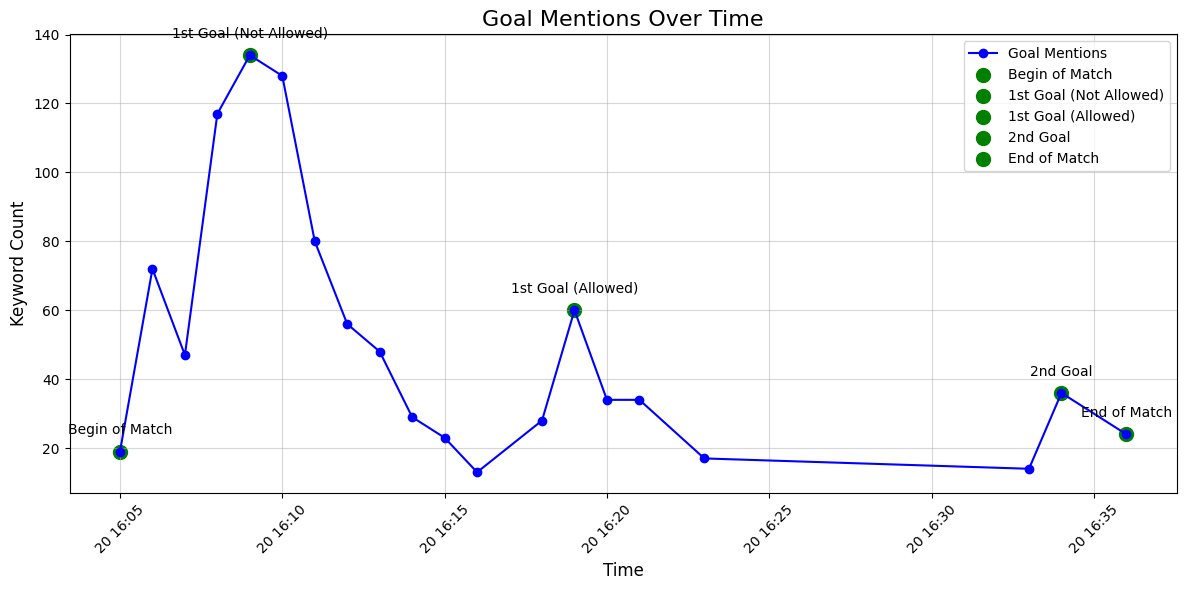

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Data with timestamps and goal keyword counts
data = {
    "time_bucket": [
        "2022-11-20 16:09:00+00:00",
        "2022-11-20 16:10:00+00:00",
        "2022-11-20 16:08:00+00:00",
        "2022-11-20 16:11:00+00:00",
        "2022-11-20 16:06:00+00:00",
        "2022-11-20 16:19:00+00:00",
        "2022-11-20 16:12:00+00:00",
        "2022-11-20 16:13:00+00:00",
        "2022-11-20 16:07:00+00:00",
        "2022-11-20 16:34:00+00:00",
        "2022-11-20 16:20:00+00:00",
        "2022-11-20 16:21:00+00:00",
        "2022-11-20 16:14:00+00:00",
        "2022-11-20 16:18:00+00:00",
        "2022-11-20 16:36:00+00:00",
        "2022-11-20 16:15:00+00:00",
        "2022-11-20 16:05:00+00:00",
        "2022-11-20 16:23:00+00:00",
        "2022-11-20 16:33:00+00:00",
        "2022-11-20 16:16:00+00:00"
    ],
    "Goal_Keyword_Count": [134, 128, 117, 80, 72, 60, 56, 48, 47, 36, 34, 34, 29, 28, 24, 23, 19, 17, 14, 13]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Ensure time_bucket is in datetime format
df["time_bucket"] = pd.to_datetime(df["time_bucket"])

# Sort the DataFrame by time_bucket
df = df.sort_values(by="time_bucket")

# Important events with descriptions
events = {
    "Begin of Match": "2022-11-20 16:00:00+00:00",
    "1st Goal (Not Allowed)": "2022-11-20 16:09:00+00:00",
    "1st Goal (Allowed)": "2022-11-20 16:19:00+00:00",
    "2nd Goal": "2022-11-20 16:34:00+00:00",
    "End of Match": "2022-11-20 17:00:00+00:00"
}

# Convert event timestamps to datetime
event_timestamps = {name: pd.to_datetime(timestamp) for name, timestamp in events.items()}

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df["time_bucket"], df["Goal_Keyword_Count"], label="Goal Mentions", marker="o", color="blue")

# Mark events on the graph
for name, timestamp in event_timestamps.items():
    # Find the closest time_bucket to the event timestamp
    closest_idx = (df["time_bucket"] - timestamp).abs().idxmin()
    closest_time = df.loc[closest_idx, "time_bucket"]
    closest_count = df.loc[closest_idx, "Goal_Keyword_Count"]
    plt.scatter(closest_time, closest_count, color="green", s=100, label=name)
    plt.text(closest_time, closest_count + 5, name, fontsize=10, ha="center")

# Add labels and legend
plt.title("Goal Mentions Over Time", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Keyword Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import re
from collections import Counter
from langdetect import detect
import nltk

# Ensure necessary NLTK dependencies are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
tweets = pd.read_csv(r'C:\Users\HP\Desktop\fifa_world_cup_2022_tweets.csv')

# Clean tweet text
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    return text.strip()

tweets["Cleaned_Tweet"] = tweets["Tweet"].apply(clean_tweet)

# Filter for English tweets
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

tweets = tweets[tweets["Cleaned_Tweet"].apply(is_english)]

# Remove punctuation and make lowercase
tweets["Cleaned_Tweet"] = tweets["Cleaned_Tweet"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

# Define goal-related keywords
goal_keywords = {"goal", "scored", "win", "final", "match", "score", "result"}

# Extract goal-related keywords
def extract_goal_keywords(text):
    keywords = [word for word in text.split() if word in goal_keywords]  # Goal-related words
    return keywords

tweets["Goal_Keywords"] = tweets["Cleaned_Tweet"].apply(extract_goal_keywords)

# Group by timestamp and create time buckets
tweets["Date Created"] = pd.to_datetime(tweets["Date Created"])
tweets["time_bucket"] = tweets["Date Created"].dt.floor("1min")

# Aggregate data by time bucket
def aggregate_goal_keywords(group):
    # Aggregate keywords
    keywords = Counter([kw for keywords in group["Goal_Keywords"] for kw in keywords])
    return {"keywords": keywords}

aggregated_data = tweets.groupby("time_bucket").apply(aggregate_goal_keywords).reset_index(name="Aggregated_Data")

# Add a new column for the count of 'goal' keyword occurrences
aggregated_data["Goal_Keyword_Count"] = aggregated_data["Aggregated_Data"].apply(lambda x: x["keywords"].get("goal", 0))

# Extract the top 20 timestamps with the highest goal counts
top_20_peaks = aggregated_data.nlargest(20, "Goal_Keyword_Count")

# Print the top 20 timestamps and their goal counts
print("\nTop 20 Timestamps with Highest Goal Counts:")
print(top_20_peaks[["time_bucket", "Goal_Keyword_Count"]])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 20 Timestamps with Highest Goal Counts:
                  time_bucket  Goal_Keyword_Count
947 2022-11-20 16:09:00+00:00                 134
948 2022-11-20 16:10:00+00:00                 128
946 2022-11-20 16:08:00+00:00                 117
949 2022-11-20 16:11:00+00:00                  80
944 2022-11-20 16:06:00+00:00                  71
957 2022-11-20 16:19:00+00:00                  60
950 2022-11-20 16:12:00+00:00                  56
951 2022-11-20 16:13:00+00:00                  48
945 2022-11-20 16:07:00+00:00                  47
972 2022-11-20 16:34:00+00:00                  36
958 2022-11-20 16:20:00+00:00                  34
959 2022-11-20 16:21:00+00:00                  34
952 2022-11-20 16:14:00+00:00                  29
956 2022-11-20 16:18:00+00:00                  28
974 2022-11-20 16:36:00+00:00                  24
953 2022-11-20 16:15:00+00:00                  23
943 2022-11-20 16:05:00+00:00                  19
961 2022-11-20 16:23:00+00:00                  17
971 2

C:\Users\HP\AppData\Local\Temp\ipykernel_4440\374340304.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = tweets.groupby("time_bucket").apply(aggregate_goal_keywords).reset_index(name="Aggregated_Data")


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# List of significant event timestamps (only timestamps, no keywords)
significant_events = [
    "2022-11-20 09:58:00+00:00", "2022-11-20 10:58:00+00:00", "2022-11-20 14:42:00+00:00",
    "2022-11-20 14:58:00+00:00", "2022-11-20 16:02:00+00:00", "2022-11-20 16:04:00+00:00",
    "2022-11-20 16:06:00+00:00", "2022-11-20 16:16:00+00:00", "2022-11-20 16:32:00+00:00", 
    "2022-11-20 17:58:00+00:00"
]

# Data for Top 20 Timestamps with Highest Goal Counts
top_20_data = {
    "time_bucket": [
        "2022-11-20 16:09:00+00:00", "2022-11-20 16:10:00+00:00", "2022-11-20 16:08:00+00:00",
        "2022-11-20 16:11:00+00:00", "2022-11-20 16:06:00+00:00", "2022-11-20 16:19:00+00:00",
        "2022-11-20 16:12:00+00:00", "2022-11-20 16:13:00+00:00", "2022-11-20 16:07:00+00:00",
        "2022-11-20 16:34:00+00:00", "2022-11-20 16:20:00+00:00", "2022-11-20 16:21:00+00:00",
        "2022-11-20 16:14:00+00:00", "2022-11-20 16:18:00+00:00", "2022-11-20 16:36:00+00:00",
        "2022-11-20 16:15:00+00:00", "2022-11-20 16:05:00+00:00", "2022-11-20 16:23:00+00:00",
        "2022-11-20 16:32:00+00:00", "2022-11-20 16:16:00+00:00"
    ],
    "Goal_Keyword_Count": [
        134, 128, 117, 80, 71, 60, 56, 48, 47, 36, 34, 34, 29, 28, 24, 23, 19, 17, 14, 13
    ]
}

# Convert both lists into DataFrames
significant_events_df = pd.DataFrame({"time_bucket": pd.to_datetime(significant_events)})
top_20_df = pd.DataFrame(top_20_data)
top_20_df["time_bucket"] = pd.to_datetime(top_20_df["time_bucket"])

# Sort the dataframes by 'time_bucket' before merging
significant_events_df.sort_values(by="time_bucket", inplace=True)
top_20_df.sort_values(by="time_bucket", inplace=True)

# Merge the two DataFrames on 'time_bucket', with an outer join to include all timestamps from both datasets
combined_df = pd.merge(significant_events_df, top_20_df, on="time_bucket", how="left")

# Fill in Goal_Count as NaN for timestamps that don't match in the top 20 dataset
combined_df["Goal_Keyword_Count"] = combined_df["Goal_Keyword_Count"].fillna(0)

# Remove rows where Goal_Keyword_Count is 0
combined_df = combined_df[combined_df["Goal_Keyword_Count"] > 0]

# Sort the combined dataframe by 'time_bucket' for clarity
combined_df.sort_values(by="time_bucket", inplace=True)

# Define the base time "2022-11-20 16:00:00" and make it timezone-aware (UTC)
base_time = pd.to_datetime("2022-11-20 16:00:00+00:00")

# Calculate the difference between the event time and 16:00:00
combined_df['time_diff'] = combined_df['time_bucket'] - base_time

# Convert the time difference into minutes and seconds (mm:ss format)
combined_df['time_only'] = combined_df['time_diff'].dt.total_seconds() // 60
combined_df['seconds'] = combined_df['time_diff'].dt.total_seconds() % 60

# Ensure seconds and minutes are formatted correctly with leading zeros (mm:ss)
combined_df['formatted_time'] = combined_df['time_only'].apply(lambda x: f"{int(x):02}") + ":" + combined_df['seconds'].apply(lambda x: f"{int(x):02}")

# Display the final combined data
print("\nCombined Significant Event Timestamps and Goal Counts:")
print(combined_df)




Combined Significant Event Timestamps and Goal Counts:
                time_bucket  Goal_Keyword_Count       time_diff  time_only  \
6 2022-11-20 16:06:00+00:00                71.0 0 days 00:06:00        6.0   
7 2022-11-20 16:16:00+00:00                13.0 0 days 00:16:00       16.0   
8 2022-11-20 16:32:00+00:00                14.0 0 days 00:32:00       32.0   

   seconds formatted_time  
6      0.0          06:00  
7      0.0          16:00  
8      0.0          32:00  
